In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import random
import statistics


from config import cfg
from common import Dimensions

from heatmap_recognize import (
    general_dim_infer,
    find_sequence_start_end_pos,
    find_all_vertex,
    refresh_image_pixels_mat,
    find_dark_col,
    filter_cold_from_warm,
)

### Read the heatmap image into both gray scale and RGB

In [84]:
# read rgb  and gray scale heatmap

image = cv2.imread(cfg.image_path)

# convert rgb to gray scale
pixels_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# convert image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels_rgb = np.array(image_rgb)

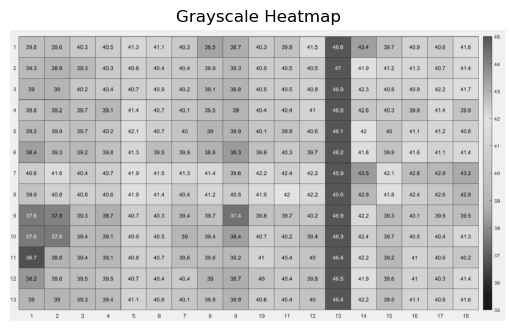

In [85]:
plt.imshow(pixels_gray, cmap="gray")
plt.title("Grayscale Heatmap")
plt.axis("off")
plt.show()

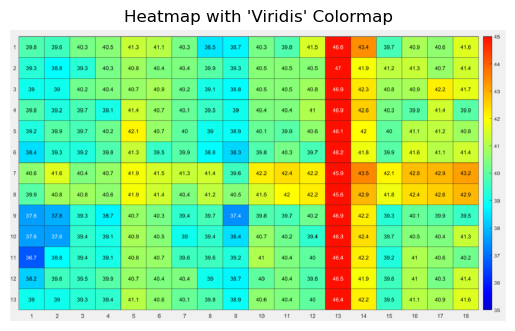

In [86]:
plt.imshow(pixels_rgb, cmap="viridis")
plt.title("Heatmap with 'Viridis' Colormap")
plt.axis("off")
plt.show()

### Inferring the heatmap's #cols and #rows

In [87]:
target_col, ids_dict_col = general_dim_infer(
    pixel_mat=pixels_gray,
    random_seq_pick_num=cfg.sequence_numbers,
    obj="col",
    filters=cfg.filters,
    tolerance=cfg.tolerance,
)

In [88]:
target_row, ids_dict_row = general_dim_infer(
    pixel_mat=pixels_gray,
    random_seq_pick_num=cfg.sequence_numbers,
    obj="row",
    filters=cfg.filters,
    tolerance=cfg.tolerance,
)

In [89]:
target_col

18

In [90]:
target_row

13

### calculate all cells' vertex coordinates 

In [91]:
start_end_index_tup_col = find_sequence_start_end_pos(
    pixel_mat=pixels_gray,
    ids=ids_dict_col,
    target=target_col,
    obj="col",
    tolerance=cfg.tolerance,
)

In [92]:
start_end_index_tup_row = find_sequence_start_end_pos(
    pixel_mat=pixels_gray,
    ids=ids_dict_row,
    target=target_row,
    obj="row",
    tolerance=cfg.tolerance,
)

In [93]:
start_end_index_tup_col

[(27, 98),
 (102, 173),
 (176, 246),
 (251, 321),
 (325, 395),
 (400, 471),
 (475, 546),
 (552, 623),
 (627, 699),
 (703, 774),
 (777, 848),
 (852, 923),
 (927, 998),
 (1002, 1073),
 (1079, 1150),
 (1154, 1225),
 (1229, 1300),
 (1303, 1374)]

In [94]:
start_end_index_tup_row

[(22, 78),
 (83, 140),
 (145, 201),
 (207, 263),
 (269, 327),
 (331, 388),
 (393, 450),
 (454, 511),
 (516, 572),
 (578, 634),
 (639, 696),
 (701, 757),
 (763, 819)]

In [95]:
all_vertex = find_all_vertex(
    row_vertex=start_end_index_tup_row, col_vertex=start_end_index_tup_col
)

In [96]:
all_vertex

[[(27, 22), (27, 78), (98, 22), (98, 78)],
 [(102, 22), (102, 78), (173, 22), (173, 78)],
 [(176, 22), (176, 78), (246, 22), (246, 78)],
 [(251, 22), (251, 78), (321, 22), (321, 78)],
 [(325, 22), (325, 78), (395, 22), (395, 78)],
 [(400, 22), (400, 78), (471, 22), (471, 78)],
 [(475, 22), (475, 78), (546, 22), (546, 78)],
 [(552, 22), (552, 78), (623, 22), (623, 78)],
 [(627, 22), (627, 78), (699, 22), (699, 78)],
 [(703, 22), (703, 78), (774, 22), (774, 78)],
 [(777, 22), (777, 78), (848, 22), (848, 78)],
 [(852, 22), (852, 78), (923, 22), (923, 78)],
 [(927, 22), (927, 78), (998, 22), (998, 78)],
 [(1002, 22), (1002, 78), (1073, 22), (1073, 78)],
 [(1079, 22), (1079, 78), (1150, 22), (1150, 78)],
 [(1154, 22), (1154, 78), (1225, 22), (1225, 78)],
 [(1229, 22), (1229, 78), (1300, 22), (1300, 78)],
 [(1303, 22), (1303, 78), (1374, 22), (1374, 78)],
 [(27, 83), (27, 140), (98, 83), (98, 140)],
 [(102, 83), (102, 140), (173, 83), (173, 140)],
 [(176, 83), (176, 140), (246, 83), (246, 14

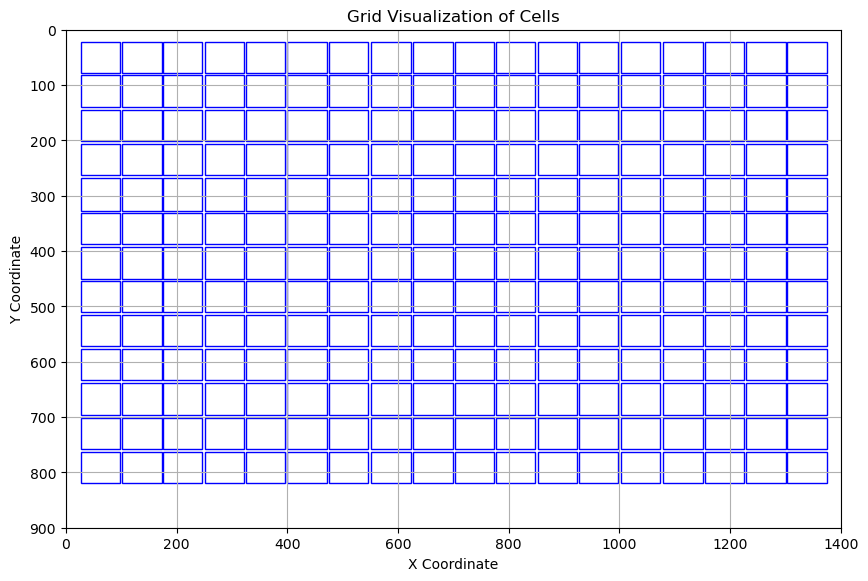

In [97]:
# draw an plot to show the cell location based off the vertex coordinates we got above
fig, ax = plt.subplots(figsize=(10, 8))

for y1, y2 in start_end_index_tup_row:
    for x1, x2 in start_end_index_tup_col:
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=None, edgecolor="blue", linewidth=1
        )
        ax.add_patch(rect)


ax.set_xlim(0, 1400)
ax.set_ylim(0, 900)
ax.set_aspect("equal", adjustable="box")
ax.invert_yaxis()

ax.grid(True)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Grid Visualization of Cells")
plt.show()

### refresh the image pixel matrix, which could erase the numbers on cells and just leave the color information

In [98]:
# this function would do processing on each cell and refreash the whole grid one by one
# the colorful image has 3 layers, red green and blue, we need to process them one by one
pixels_rgb_red = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 0],
)
pixels_rgb_green = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 1],
)
pixels_rgb_blue = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 2],
)

In [99]:
# stack these updated 3 layers together
refreshed_rgb_pixels = np.dstack((pixels_rgb_red, pixels_rgb_green, pixels_rgb_blue))

In [100]:
refreshed_rgb_pixels

array([[[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]],

       [[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]],

       [[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]],

       ...,

       [[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]],

       [[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]],

       [[240, 240, 240],
        [240, 240, 240],
        [240, 240, 240],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [255, 255, 255]]

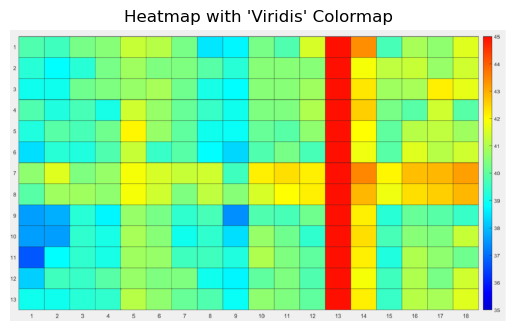

In [101]:
plt.imshow(refreshed_rgb_pixels, cmap="viridis")
plt.title("Heatmap with 'Viridis' Colormap")
plt.axis("off")
plt.show()

In [102]:
refreshed_gray_pixels = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_gray,
)

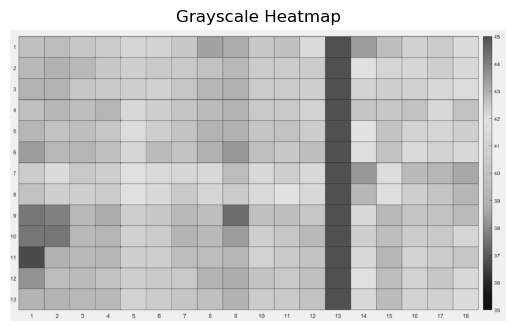

In [103]:
plt.imshow(refreshed_gray_pixels, cmap="gray")
plt.title("Grayscale Heatmap")
plt.axis("off")
plt.show()

### locate the column where cells are all overheat

In [104]:
cols_overheat_gray = find_dark_col(
    row_vertex=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    dark_value=cfg.dark_value,
    pixel_mat=refreshed_gray_pixels,
)

In [105]:
cols_overheat_gray

[13]

### filter overcold col and just leave overheat col

In [106]:
overheat_col_id = filter_cold_from_warm(
    row_vertex=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    col_ids=cols_overheat_gray,
    temperature_differ=cfg.temperature_differ,
    image_rgb=refreshed_rgb_pixels,
)

In [107]:
overheat_col_id

[13]

### 2nd demo. use heatmap with 1 overheated image and 1 overcolded image

In [108]:
# read rgb  and gray scale heatmap

image = cv2.imread("./data/test2.jpg")

# convert rgb to gray scale
pixels_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# convert image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels_rgb = np.array(image_rgb)

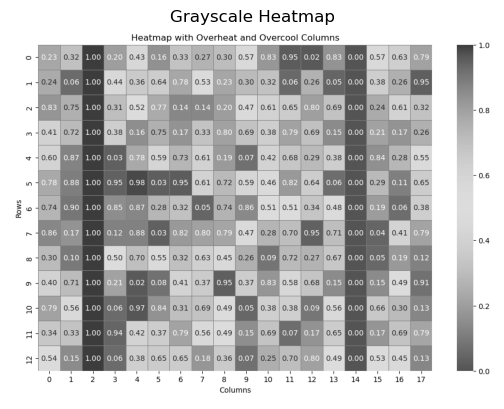

In [109]:
plt.imshow(pixels_gray, cmap="gray")
plt.title("Grayscale Heatmap")
plt.axis("off")
plt.show()

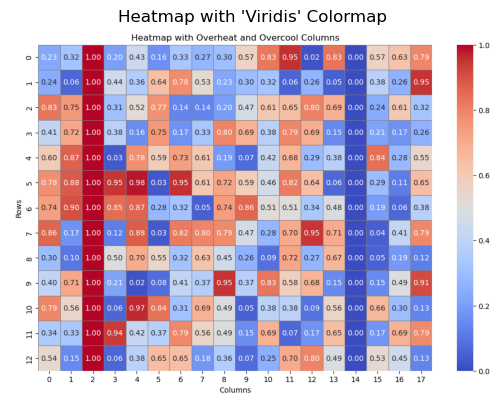

In [110]:
plt.imshow(pixels_rgb, cmap="viridis")
plt.title("Heatmap with 'Viridis' Colormap")
plt.axis("off")
plt.show()

In [111]:
target_col, ids_dict_col = general_dim_infer(
    pixel_mat=pixels_gray,
    random_seq_pick_num=cfg.sequence_numbers,
    obj="col",
    filters=cfg.filters,
    tolerance=cfg.tolerance,
)

In [112]:
target_row, ids_dict_row = general_dim_infer(
    pixel_mat=pixels_gray,
    random_seq_pick_num=cfg.sequence_numbers,
    obj="row",
    filters=cfg.filters,
    tolerance=cfg.tolerance,
)

In [113]:
start_end_index_tup_col = find_sequence_start_end_pos(
    pixel_mat=pixels_gray,
    ids=ids_dict_col,
    target=target_col,
    obj="col",
    tolerance=cfg.tolerance,
)
start_end_index_tup_row = find_sequence_start_end_pos(
    pixel_mat=pixels_gray,
    ids=ids_dict_row,
    target=target_row,
    obj="row",
    tolerance=cfg.tolerance,
)

In [114]:
all_vertex = find_all_vertex(
    row_vertex=start_end_index_tup_row, col_vertex=start_end_index_tup_col
)

In [115]:
# this function would do processing on each cell and refreash the whole grid one by one
# the colorful image has 3 layers, red green and blue, we need to process them one by one
pixels_rgb_red = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 0],
)
pixels_rgb_green = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 1],
)
pixels_rgb_blue = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_rgb[:, :, 2],
)

In [116]:
# stack these updated 3 layers together
refreshed_rgb_pixels = np.dstack((pixels_rgb_red, pixels_rgb_green, pixels_rgb_blue))

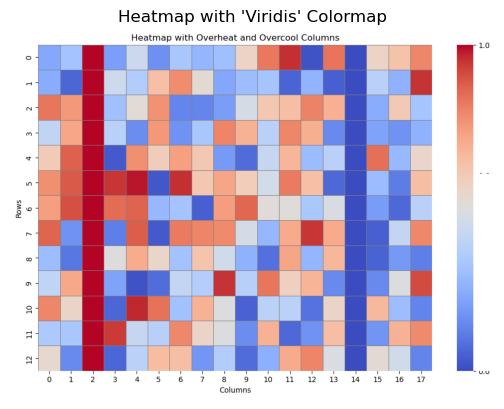

In [117]:
plt.imshow(refreshed_rgb_pixels, cmap="viridis")
plt.title("Heatmap with 'Viridis' Colormap")
plt.axis("off")
plt.show()

In [118]:
refreshed_gray_pixels = refresh_image_pixels_mat(
    row_vertx=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    pixel_mat=pixels_gray,
)

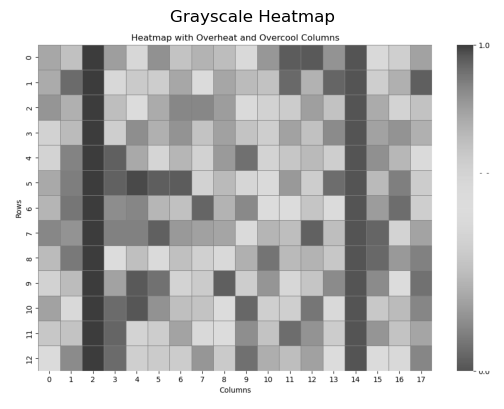

In [119]:
plt.imshow(refreshed_gray_pixels, cmap="gray")
plt.title("Grayscale Heatmap")
plt.axis("off")
plt.show()

In [120]:
cols_overheat_gray = find_dark_col(
    row_vertex=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    dark_value=cfg.dark_value,
    pixel_mat=refreshed_gray_pixels,
)

In [121]:
cols_overheat_gray

[3, 15]

here we need to give a notice that, because we have 1 all overcolded col and 1 all overheated col in the heatmap, and gray scale image can not distingush both them. we get 2 col ids return.

In [122]:
overheat_col_id = filter_cold_from_warm(
    row_vertex=start_end_index_tup_row,
    col_vertex=start_end_index_tup_col,
    col_ids=cols_overheat_gray,
    temperature_differ=cfg.temperature_differ,
    image_rgb=refreshed_rgb_pixels,
)

In [123]:
overheat_col_id

[3]

We make one more step judgment and find the correct col id finally